# Zillow Prize: Zillow’s Home Value Prediction (Zestimate)

- Zestimate과 실제 판매 가격 사이의 log-error 값을 예측  
𝑙𝑜𝑔𝑒𝑟𝑟𝑜𝑟=𝑙𝑜𝑔(𝑍𝑒𝑠𝑡𝑖𝑚𝑎𝑡𝑒)−𝑙𝑜𝑔(𝑆𝑎𝑙𝑒𝑃𝑟𝑖𝑐𝑒)
- 2017년 가을의 log-error 값 예측을 목표로 함
  

## 데이터셋 설명
- 미국 세 지역(Los Angeles, Orange and Ventura, California)의 부동산 정보 리스트 제공
- train data: 2016-10-15 이전의 모든 거래 데이터와 그 이후 시점의 일부 데이터
- test data: train data에 포함되지 않은 2016-10-15와 2016-12-31 사이의 거래내역 데이터
  - 이 기간은 "sales tracking period"라고 부름
- 6개 시점의 값 예측을 목표로 함
  - 201610, 201611, 201612, 201710, 201711, 201712
- 집이 거래되지 않은 시점도 존재함 -> 거래되지 않은 시점의 행은 점수 계산에서 ignore
- 한 달 내 하나의 집이 여러 번 거래된 경우, 첫 번째 값을 사용

### Settings

In [1]:
import os
import sys
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
os.chdir('/Users/dayoungcho/Downloads/zillow-prize-1')
os.getcwd()

'/Users/dayoungcho/Downloads/zillow-prize-1'

In [3]:
import gc
import numpy as np
from numpy import hstack
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
from scipy import stats
from scipy.stats import norm, skew

In [4]:
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [5]:
from sklearn import __version__
__version__

'1.0.2'

### Import datasets

In [6]:
pd.read_csv('properties_2016.csv')

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.000,NaN,NaN,NaN,NaN,NaN,NaN,34144442.000,-118654084.000,85768.000,NaN,NaN,NaN,NaN,NaN,010D,269.000,NaN,60378002.041,37688.000,3101.000,NaN,96337.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.000,2015.000,9.000,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6037.000,NaN,NaN,NaN,NaN,NaN,NaN,34140430.000,-118625364.000,4083.000,NaN,NaN,NaN,NaN,NaN,0109,261.000,LCA11*,60378001.011,37688.000,3101.000,NaN,96337.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27516.000,2015.000,27516.000,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.000,0.000,NaN,NaN,NaN,NaN,NaN,73026.000,NaN,NaN,73026.000,NaN,NaN,6037.000,NaN,NaN,NaN,NaN,NaN,NaN,33989359.000,-118394633.000,63085.000,NaN,NaN,NaN,NaN,NaN,1200,47.000,LAC2,60377030.012,51617.000,3101.000,NaN,96095.000,0.000,NaN,NaN,NaN,2.000,NaN,NaN,NaN,NaN,NaN,650756.000,1413387.000,2015.000,762631.000,20800.370,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.000,0.000,3.000,7.000,NaN,NaN,NaN,5068.000,NaN,NaN,5068.000,NaN,NaN,6037.000,NaN,NaN,NaN,NaN,NaN,NaN,34148863.000,-118437206.000,7521.000,NaN,NaN,NaN,NaN,NaN,1200,47.000,LAC2,60371412.023,12447.000,3101.000,27080.000,96424.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,1948.000,1.000,NaN,571346.000,1156834.000,2015.000,585488.000,14557.570,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.000,0.000,4.000,NaN,NaN,NaN,NaN,1776.000,NaN,NaN,1776.000,NaN,NaN,6037.000,NaN,NaN,NaN,NaN,NaN,NaN,34194168.000,-118385816.000,8512.000,NaN,NaN,NaN,NaN,NaN,1210,31.000,LAM1,60371232.052,12447.000,3101.000,46795.000,96450.000,0.000,NaN,NaN,NaN,1.000,NaN,NaN,1947.000,NaN,NaN,193796.000,433491.000,2015.000,239695.000,5725.170,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2985212,168176230,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2985213,14273630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2985214,168040630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2985215,168040830,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
pd.read_csv('train_2016_v2.csv')

,parcelid,logerror,transactiondate
0,11016594,0.028,2016-01-01
1,14366692,-0.168,2016-01-01
2,12098116,-0.004,2016-01-01
3,12643413,0.022,2016-01-02
4,14432541,-0.005,2016-01-02
...,...,...,...
90270,10774160,-0.036,2016-12-30
90271,12046695,0.007,2016-12-30
90272,12995401,-0.268,2016-12-30
90273,11402105,0.060,2016-12-30


In [8]:
PROPERTIES_2016 = 'properties_2016.csv'
PROPERTIES_2017 = 'properties_2017.csv'
TRAIN_2016 = 'train_2016_v2.csv'
TRAIN_2017 = 'train_2017.csv'

def load_housing_data():
  properties_2016 = pd.read_csv(PROPERTIES_2016)
  properties_2017 = pd.read_csv(PROPERTIES_2017)
  train_2016 = pd.read_csv(TRAIN_2016)
  train_2017 = pd.read_csv(TRAIN_2017)

  train_2016 = pd.merge(train_2016, properties_2016, how='left', on='parcelid')
  train_2017 = pd.merge(train_2017, properties_2017, how='left', on='parcelid')

  all_properties = pd.concat([properties_2016, properties_2017], ignore_index = True)
  all_training = pd.concat([train_2016, train_2017], ignore_index = True)

  return all_properties, all_training

In [9]:
all_properties, housing = load_housing_data()
housing.head()

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,hashottuborspa,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid10,pooltypeid2,pooltypeid7,propertycountylandusecode,propertylandusetypeid,propertyzoningdesc,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.028,2016-01-01,1.000,NaN,NaN,2.000,3.000,NaN,4.000,2.000,NaN,NaN,1684.000,1684.000,NaN,NaN,NaN,NaN,6037.000,NaN,2.000,NaN,NaN,NaN,2.000,34280990.000,-118488536.000,7528.000,NaN,NaN,NaN,NaN,NaN,0100,261.000,LARS,60371066.461,12447.000,3101.000,31817.000,96370.000,0.000,NaN,NaN,NaN,1.000,NaN,NaN,1959.000,NaN,NaN,122754.000,360170.000,2015.000,237416.000,6735.880,NaN,NaN,60371066461001.000
1,14366692,-0.168,2016-01-01,NaN,NaN,NaN,3.500,4.000,NaN,NaN,3.500,NaN,NaN,2263.000,2263.000,NaN,NaN,NaN,NaN,6059.000,NaN,3.000,2.000,468.000,NaN,NaN,33668120.000,-117677556.000,3643.000,NaN,NaN,NaN,NaN,NaN,1,261.000,NaN,60590524.222,32380.000,1286.000,NaN,96962.000,0.000,NaN,1.000,NaN,NaN,NaN,NaN,2014.000,NaN,NaN,346458.000,585529.000,2015.000,239071.000,10153.020,NaN,NaN,NaN
2,12098116,-0.004,2016-01-01,1.000,NaN,NaN,3.000,2.000,NaN,4.000,3.000,NaN,NaN,2217.000,2217.000,NaN,NaN,NaN,NaN,6037.000,NaN,3.000,NaN,NaN,NaN,2.000,34136312.000,-118175032.000,11423.000,NaN,NaN,NaN,NaN,NaN,0100,261.000,PSR6,60374638.003,47019.000,3101.000,275411.000,96293.000,0.000,NaN,NaN,NaN,1.000,NaN,NaN,1940.000,NaN,NaN,61994.000,119906.000,2015.000,57912.000,11484.480,NaN,NaN,60374638003004.000
3,12643413,0.022,2016-01-02,1.000,NaN,NaN,2.000,2.000,NaN,4.000,2.000,NaN,NaN,839.000,839.000,NaN,NaN,NaN,NaN,6037.000,NaN,2.000,NaN,NaN,NaN,2.000,33755800.000,-118309000.000,70859.000,NaN,NaN,NaN,NaN,NaN,010C,266.000,LAR3,60372963.002,12447.000,3101.000,54300.000,96222.000,0.000,NaN,NaN,NaN,1.000,NaN,NaN,1987.000,NaN,NaN,171518.000,244880.000,2015.000,73362.000,3048.740,NaN,NaN,60372963002002.000
4,14432541,-0.005,2016-01-02,NaN,NaN,NaN,2.500,4.000,NaN,NaN,2.500,NaN,NaN,2283.000,2283.000,NaN,NaN,NaN,NaN,6059.000,NaN,2.000,2.000,598.000,NaN,NaN,33485643.000,-117700234.000,6000.000,1.000,NaN,NaN,NaN,1.000,122,261.000,NaN,60590423.381,17686.000,1286.000,NaN,96961.000,8.000,NaN,1.000,NaN,NaN,NaN,NaN,1981.000,2.000,NaN,169574.000,434551.000,2015.000,264977.000,5488.960,NaN,NaN,60590423381006.000


In [10]:
print("Total Properties Shape: {}".format(all_properties.shape))
print("-"*50)
housing.info()

Total Properties Shape: (5970434, 58)
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167888 entries, 0 to 167887
Data columns (total 60 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   parcelid                      167888 non-null  int64  
 1   logerror                      167888 non-null  float64
 2   transactiondate               167888 non-null  object 
 3   airconditioningtypeid         53788 non-null   float64
 4   architecturalstyletypeid      468 non-null     float64
 5   basementsqft                  93 non-null      float64
 6   bathroomcnt                   167854 non-null  float64
 7   bedroomcnt                    167854 non-null  float64
 8   buildingclasstypeid           31 non-null      float64
 9   buildingqualitytypeid         107173 non-null  float64
 10  calculatedbathnbr             166056 non-null  float64
 11  decktypeid     

- total # of properties: 5.97m
- var. type: 53 Float64, 6 object(categorical), 1 integer(ParcelID)
- variables with missing data: 많음ㅋㅋ => imputation/dropping 대상

In [11]:
# 중복값 찾아서 drop

def check_duplicates(housing):
    idsUnique = len(housing[['parcelid', 'transactiondate']].value_counts())
    idsTotal = housing.shape[0]
    idsDupli = idsTotal - idsUnique
    print(str(idsTotal) + "개의 데이터 중 " + str(idsDupli) + "개의 중복 데이터 존재")

def drop_duplicates(housing):
    print("parcelid와 transactiondate 기반으로 중복 데이터 삭제중..")
    return housing.drop_duplicates(subset=['parcelid','transactiondate'], keep='last',ignore_index=True)

In [12]:
check_duplicates(housing)
housing = drop_duplicates(housing)

check_duplicates(housing)

167888개의 데이터 중 0개의 중복 데이터 존재
parcelid와 transactiondate 기반으로 중복 데이터 삭제중..
167888개의 데이터 중 0개의 중복 데이터 존재


## 전처리

### Dropping Outliers

#### target variable: logerror

In [13]:
y = housing.logerror

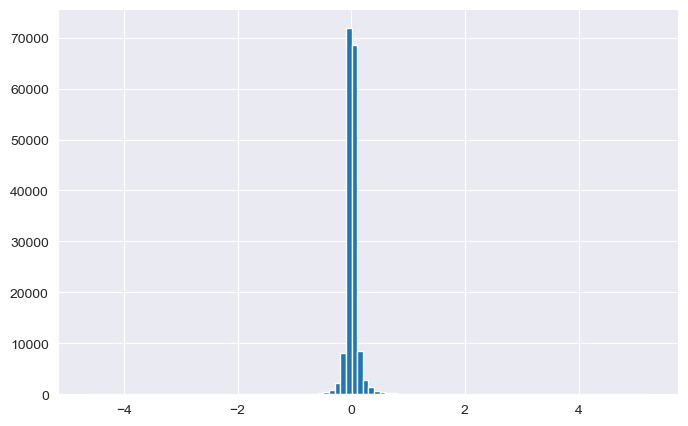

In [14]:
y.hist(bins=100, figsize=(8,5))
plt.show()

In [15]:
y.describe

<bound method NDFrame.describe of 0         0.028
1        -0.168
2        -0.004
3         0.022
4        -0.005
          ...  
167883   -0.002
167884    0.021
167885    0.013
167886    0.037
167887    0.007
Name: logerror, Length: 167888, dtype: float64>


 mu = 0.01 and sigma = 0.17



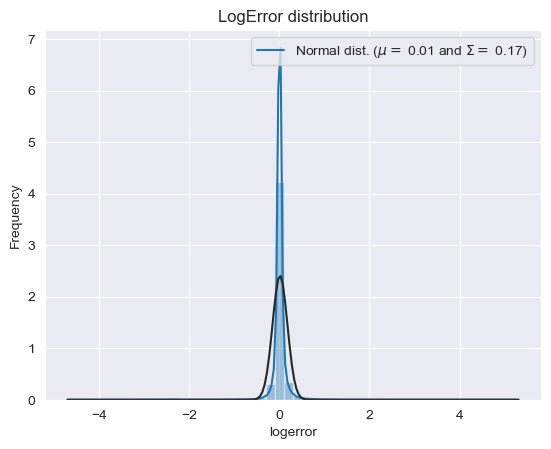

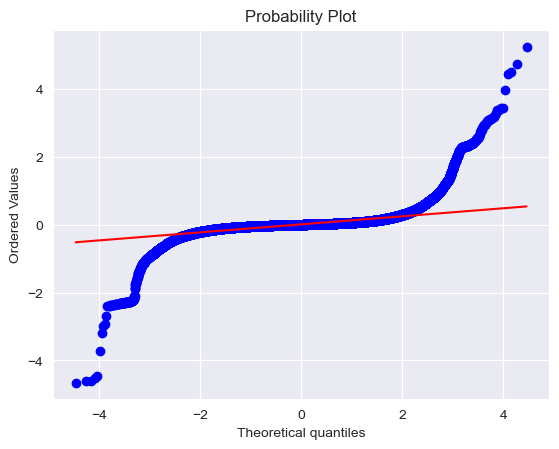

In [16]:
sns.distplot(y, fit=norm);
(mu, sigma) = norm.fit(y)
print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\Sigma=$ {:.2f})'.format(mu,sigma)],
           loc = 'best')
plt.ylabel("Frequency")
plt.title("LogError distribution")

fig = plt.figure()
res = stats.probplot(y,plot=plt)
plt.show()

skewed & outlier를 포함함  
- 이런 경우 로그변환을 통해 정규분포를 따르게 변환
- But 이 대회의 경우에는 이상한 케이스들을 제외하고 예측하는게 더 나음~

#### drop

- y가 $\mu+2.5\sigma$ 이상/이하인 값을 drop
- 75% 이상이 결측치인 변수 drop

In [17]:
highest_thres = y.mean() + 2.5 * y.std()
lowest_thres = y.mean() - 2.5 * y.std()
print("Highest allowed", highest_thres)
print("Lowest allowed", lowest_thres)

Highest allowed 0.42817114871087447
Lowest allowed -0.4003585363683907


In [18]:
y = y[y>lowest_thres]
y = y[y<highest_thres]

housing = housing[housing.logerror > lowest_thres]
housing = housing[housing.logerror < highest_thres]

In [19]:
percent = 75.0
min_count = int( ( (100-percent)/100) * housing.shape[1] + 1)
housing = housing.dropna(axis=0, thresh=min_count)
housing.shape

(164538, 60)

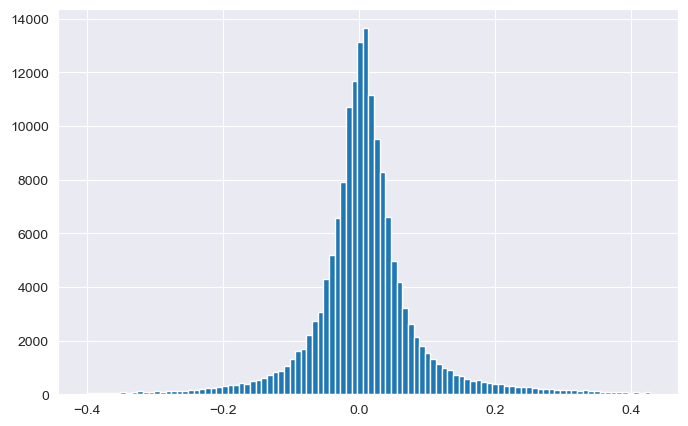

In [20]:
y.hist(bins=100, figsize=(8,5))
plt.show()


 mu = 0.01 and sigma = 0.08



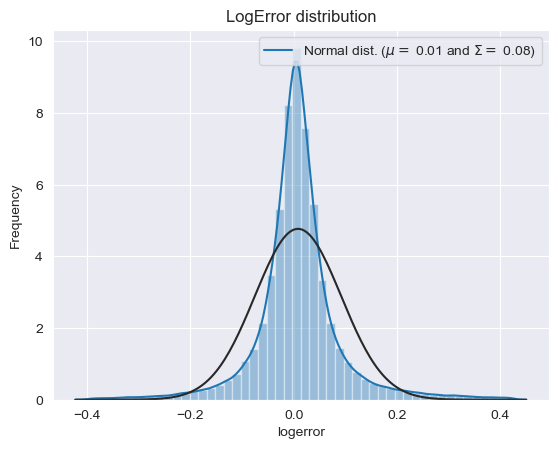

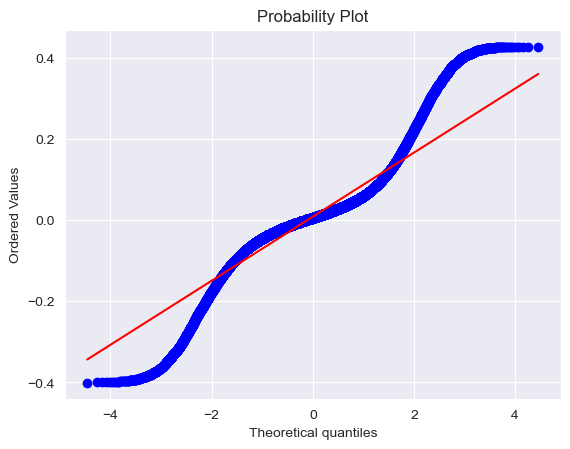

In [21]:
sns.distplot(y, fit=norm);
(mu, sigma) = norm.fit(y)
print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\Sigma=$ {:.2f})'.format(mu,sigma)],
           loc = 'best')
plt.ylabel("Frequency")
plt.title("LogError distribution")

fig = plt.figure()
res = stats.probplot(y,plot=plt)
plt.show()


### Create Test/Train Datasets

- parcelid 칼럼을 기준값으로, crc32 모듈을 이용하여 parcelid를 특정 해쉬값으로 변환 후 그 변환값을 기준으로 split
  - crc32: 넣은 인풋값을 00000000 ~ FFFFFFFF 까지 2^32(약 43억)개의 해쉬값 중 하나로 변환해줌..
  - 초기값은 0xffffffff

In [22]:
from zlib import crc32
from sklearn.model_selection import train_test_split

for i in range(5):
    print(i, "  ", housing["parcelid"][i], "->", crc32(housing["parcelid"][i]))

0    11016594 -> 260974203
1    14366692 -> 2005238722
2    12098116 -> 1976871700
3    12643413 -> 2903306268
4    14432541 -> 3667642182


In [23]:
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32   # boolean 값 출력됨

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_ : test_set_check(id_, test_ratio))

    train_set = data.loc[~in_test_set]
    test_set = data.loc[in_test_set]

    X_train = train_set.drop("logerror",axis=1)
    y_train = train_set["logerror"].copy()

    X_test = test_set.drop("logerror",axis=1)
    y_test = test_set["logerror"].copy()

    return X_train, X_test, y_train, y_test

X_other, X_test, y_other, y_test = split_train_test_by_id(housing, 0.1, "parcelid")

print(f"Other dataset Shape: {X_other.shape} \nTest Dataset Shape: {X_test.shape}")

Other dataset Shape: (148111, 59) 
Test Dataset Shape: (16427, 59)


#### Creating Validation Sets

In [24]:
# train set을 다시 train set과 val set으로 split

X_train, X_val, y_train, y_val = train_test_split(X_other, y_other, train_size=0.9, random_state=42)
print(f"Training Dataset Shape: {X_train.shape}")    
print(f"Test Dataset Shape: {X_test.shape}")      
print(f"Validation Dataset Shape: {X_val.shape}") 

Training Dataset Shape: (133299, 59)
Test Dataset Shape: (16427, 59)
Validation Dataset Shape: (14812, 59)


In [25]:
# Clear memory
del all_properties, housing; gc.collect()

32063

### Data Preprocessing Pipelines

#### 1. dropping features

In [26]:
# missing data의 비율

all_data_na = (X_train.isnull().sum() / len(X_train)) * 100  # 전체에서 결측값이 있는 데이터의 비율
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)  # 결측값이 있는 데이터 추출
missing_data = pd.DataFrame({'Missing Ratio' : all_data_na})
missing_data[:35]


,Missing Ratio
buildingclasstypeid,99.986
finishedsquarefeet13,99.959
basementsqft,99.943
storytypeid,99.943
yardbuildingsqft26,99.903
fireplaceflag,99.771
architecturalstyletypeid,99.723
typeconstructiontypeid,99.691
finishedsquarefeet6,99.545
decktypeid,99.259


In [27]:
print("Features with one unique value")
exclude_unique =[]
for i in X_train.columns:
    num_uniques = len(X_train[i].unique())
    if X_train[i].isnull().sum() != 0:
        num_uniques -= 1
    if num_uniques == 1:
        exclude_unique.append(i)
print(exclude_unique)

Features with one unique value
['decktypeid', 'hashottuborspa', 'poolcnt', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'storytypeid', 'fireplaceflag', 'taxdelinquencyflag']


- drop candidates: imputate 대신 삭제할 변수들
  - finishedsquarefeet13, finishedsquarefeet15, finishedfloor1squarefeet, finishedsquarefeet50, storytypeid, buildingclasstypeid, architecturalstyletypeid, typeconstructiontypeid, finishedsquarefeet6, numberofstories, basementsqft, yardbuildingssqft26: 결측치가 너무 많음
  - rawcensustractandblock, censustractandblock: 58k개의 unique value -> 분석에 활용하기 어려움
  - assessmentyear: 결과값이 단 하나임
  - parcelid, transactiondate: 결과 예측에 활용할 수 없음
  - pooltypeid10, hashottuborspa, pooltypeid7, fireplaceflag, threequarterbathnbr, calculatedbathnbr, fullbathcnt, finishedsquarefeet12, taxvaluedollarcnt, roomcnt, propertyzoningdesc, propertycountylandusecode, regionidneighborhood, regionidzip, regionidcity, taxdelinquencyyear: 비슷한 정보를 제공하면서 결측치의 수는 더 적은 변수가 이미 존재함

In [28]:
X_temp = X_train.copy()

In [29]:
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureDropper(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_drop):
        self.features_to_drop = features_to_drop
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        updated_X = X.drop(self.features_to_drop, axis=1)
        return updated_X

In [30]:
lin_reg_drop_vars = ["finishedsquarefeet13", "finishedsquarefeet15", "finishedfloor1squarefeet", "finishedsquarefeet50", "storytypeid", "architecturalstyletypeid", "buildingclasstypeid", "typeconstructiontypeid", "finishedsquarefeet6", "pooltypeid10", "pooltypeid7", "hashottuborspa", "fireplaceflag", "threequarterbathnbr", "calculatedbathnbr", "fullbathcnt", "numberofstories", "rawcensustractandblock", "censustractandblock", "finishedsquarefeet12", "taxvaluedollarcnt", "taxamount", "assessmentyear", "roomcnt", "propertyzoningdesc", "regionidneighborhood", "regionidzip", "taxdelinquencyyear", "propertycountylandusecode", "regionidcity", "parcelid", "basementsqft", "yardbuildingsqft26", "transactiondate"]

feat_dropper = FeatureDropper(features_to_drop=lin_reg_drop_vars)
X_temp = feat_dropper.fit_transform(X_temp)

#### 2. data imputation

- univariate imputation: 하나의 값(mean/median/mode)으로 impute
- multivariate imputation: 다른 column의 값도 이용하여 결측치를 estimate하여 impute

둘 중 한 가지 방법을 이용하면 됨

#### 2-1. univariate imputation

3가지 방식을 사용할 예정
- 0으로 impute: 결과값이 주로 0이므로 그냥 0으로 대치
- 최빈값으로 impute: 대부분의 값이 비슷
- 중간값으로 impute

In [31]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

In [32]:
impute_0_vars = ["yardbuildingsqft17", "fireplacecnt", "poolcnt", "garagecarcnt", "garagetotalsqft", "pooltypeid2", "poolsizesum", "decktypeid", "taxdelinquencyflag"]

impute_mode_vars = ["airconditioningtypeid", "heatingorsystemtypeid", "unitcnt", "fips", "propertylandusetypeid", "regionidcounty", "yearbuilt"] 

impute_median_vars = ["buildingqualitytypeid", "lotsizesquarefeet", "bathroomcnt", "bedroomcnt", "calculatedfinishedsquarefeet", "structuretaxvaluedollarcnt", "landtaxvaluedollarcnt", "latitude", "longitude"]

In [33]:
univariate_impute_pipe = ColumnTransformer([("impute_0", SimpleImputer(strategy="constant", fill_value=0), impute_0_vars),
                                            ("impute_mode", SimpleImputer(strategy="most_frequent"), impute_mode_vars),
                                            ("impute_median", SimpleImputer(strategy="median"), impute_median_vars),],  remainder='passthrough')

X_temp = univariate_impute_pipe.fit_transform(X_temp)

#### 2-2. multivariate imputation

SimpleImputer / RandomForestRegressor 이용

In [34]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

In [35]:
cat_impute_vars = ["airconditioningtypeid", "heatingorsystemtypeid", "fips", "propertylandusetypeid", "regionidcounty", "pooltypeid2", "decktypeid", "taxdelinquencyflag"] 
numeric_impute_vars = ["bathroomcnt", "bedroomcnt", "buildingqualitytypeid", "calculatedfinishedsquarefeet", "fireplacecnt", "garagecarcnt", "garagetotalsqft", "latitude", "longitude", "lotsizesquarefeet", "poolcnt", "poolsizesum", "unitcnt", "yardbuildingsqft17", "yearbuilt", "structuretaxvaluedollarcnt", "landtaxvaluedollarcnt"]

In [36]:
multivariate_impute_pipe = ColumnTransformer([  ("impute_cats", SimpleImputer(strategy="constant", fill_value='missing'), cat_impute_vars),
                                                ("impute_num", IterativeImputer(estimator = RandomForestRegressor(n_estimators=1, max_depth=30, min_samples_leaf=32), random_state=0, max_iter=1), numeric_impute_vars)],
                                                remainder='passthrough')

#### 4. column names appender   이거 뭔지 모르겠음

In [39]:
class ColumnNamesAppender(BaseEstimator, TransformerMixin):
    def __init__(self, column_transformer, orig_columns, num_transformers):
        self.column_transformer = column_transformer
        self.orig_columns = orig_columns
        self.num_transformers = num_transformers
    def fit(self, X, y=None):
        return self  # nothing else to do 
    def transform(self, X): 
        X_column_names = self.get_columns_from_transformer(self.column_transformer, self.orig_columns, self.num_transformers)
        
        # Create dataframe from numpy array and column names 
        X = pd.DataFrame(X, columns=X_column_names)
        return X 
    @staticmethod
    def get_columns_from_transformer(column_transformer, input_colums, num_transformers):    
        col_name = []
        
        for transformer_in_columns in column_transformer.transformers_: #the last transformer is ColumnTransformer's 'remainder'
            raw_col_name = transformer_in_columns[2]
            if isinstance(transformer_in_columns[1],Pipeline): 
                transformer = transformer_in_columns[1].steps[-1][1]
            else:
                transformer = transformer_in_columns[1]
            try:
                names = transformer.get_feature_names([raw_col_name])
            except AttributeError:
                names = raw_col_name
            if isinstance(names,np.ndarray): 
                col_name += names.tolist()
            elif isinstance(names,list):
                col_name += names    
            elif isinstance(names,str):
                col_name.append(names)

        return col_name


In [40]:
column_appender = ColumnNamesAppender(univariate_impute_pipe, orig_columns= X_train.columns, num_transformers = 3)
X_temp = column_appender.fit_transform(X_temp)

#### 5. convert variables types

categorical & boolean 변수들이 float 타입으로 되어 있으므로 알맞게 변환

In [41]:
convert_to_int = ["yearbuilt"] 
convert_to_string= ["airconditioningtypeid", "heatingorsystemtypeid", "fips", "propertylandusetypeid", "regionidcounty", "pooltypeid2", "decktypeid", "taxdelinquencyflag"] 
convert_to_float= ["bathroomcnt", "bedroomcnt", "buildingqualitytypeid", "calculatedfinishedsquarefeet",
                  "fireplacecnt", "garagecarcnt", "garagetotalsqft", "latitude", "longitude", "lotsizesquarefeet", "poolcnt",
                  "poolsizesum", "unitcnt", "yardbuildingsqft17",
                  "structuretaxvaluedollarcnt", "landtaxvaluedollarcnt"]

In [42]:
class ConvertFeatureType(BaseEstimator, TransformerMixin):
    def __init__(self, convert_to_int=[], convert_to_bool=[], convert_to_string=[], convert_to_float=[]):
        self.convert_to_int = convert_to_int
        self.convert_to_bool = convert_to_bool
        self.convert_to_string = convert_to_string
        self.convert_to_float = convert_to_float
        self.features = {"int": convert_to_int, "float": convert_to_float, "boolean": convert_to_bool, "str": convert_to_string}
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        self.map_bool_features(X)
        for data_type in self.features.keys():
            X = self.convert_feature_types(X, data_type)
        return X
    
    def map_bool_features(self, X):
        for var in self.convert_to_bool:
            X[var][X[var].notnull()] = True

    def convert_feature_types(self, X, data_type):
        for var in self.features[data_type]:
            X[var] = X[var].astype(data_type)
        return X


In [43]:
feature_type_changer = ConvertFeatureType(convert_to_int = convert_to_int, convert_to_string = convert_to_string, convert_to_float = convert_to_float)
X_temp = feature_type_changer.fit_transform(X_temp)

#### 6. data feature creator

transactiondate 변수를 통해 날짜와 관련된 변수 만들기

In [50]:
class CreateDateFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X): 
        dt = pd.to_datetime(X['transactiondate']).dt
        X['transaction_year'] = (dt.year).astype('category') # 년도
        X['transaction_month'] = ((dt.year - 2016)*12 + dt.month).astype('category') # 시작지점부터 지난 달
        X['transaction_day'] = dt.day    # 일자
        X['transaction_quarter'] = ((dt.year - 2016)*4 + dt.quarter).astype('category')   # 시작지점부터 지난 분기
        X = X.drop(['transactiondate'], axis=1)
    
        return X

In [52]:
# date_feat_creator = CreateDateFeatures()
# X_temp = date_feat_creator.fit_transform(X_temp)

#### 7. year feature creation

현재 시점 기준 몇 년 전인지를 표시하는 변수

In [54]:
from datetime import date

date_features = {"yearbuilt": "house_age"}

class CreateYearFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, date_features):
        self.date_features = date_features
        self.current_year = date.today().year

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        for var in self.date_features.keys():
            new_var_name = self.date_features[var]
            X[new_var_name] = self.current_year - X[var]
            X[new_var_name] = X[new_var_name].astype('float')
            X.drop(var, axis=1, inplace=True)
        return X


In [55]:
year_feat_creator = CreateYearFeatures(date_features = date_features)
X_temp = year_feat_creator.fit_transform(X_temp)

#### 8. combining existing features

In [56]:
class CreateDerivedFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self,X):
        X['avg_garage_size'] = X['garagetotalsqft'] / X['garagecarcnt']
        X['property_tax_per_sqft'] = X['taxamount'] / X['calculatedfinishedsquarefeet']

        mask = (X.roomcnt >= 1)   # 분모가 0이 되는것을 방지
        X.loc[mask, 'avg_area_per_room'] = X.loc[mask, 'calculatedfinishedsquarefeet'] / X.loc[mask, 'roomcnt']
        
        # Derived Room Count
        X['derived_room_cnt'] = X['bedroomcnt'] + X['bathroomcnt']
        
        # Use the derived room_cnt to calculate the avg area again
        mask = (X.derived_room_cnt >= 1)
        X.loc[mask,'derived_avg_area_per_room'] = X.loc[mask,'calculatedfinishedsquarefeet'] / X.loc[mask,'derived_room_cnt']
        
        # Rotated Coordinates
        X['location_1'] = X['latitude'] + X['longitude']
        X['location_2'] = X['latitude'] - X['longitude']
        X['location_3'] = X['latitude'] + 0.5 * X['longitude']
        X['location_4'] = X['latitude'] - 0.5 * X['longitude']
        
        # 'finished_area_sqft' and 'total_area' cover only a strict subset of 'finished_area_sqft_calc' in terms of 
        # non-missing values. Also, when both fields are not null, the values are always the same.
        # So we can probably drop 'finished_area_sqft' and 'total_area' since they are redundant
        # If there're some patterns in when the values are missing, we can add two isMissing binary features
        X['missing_finished_area'] = X['finishedsquarefeet12'].isnull().astype(float)
        X['missing_total_area'] = X['finishedsquarefeet15'].isnull().astype(float)
        X = X.drop(['finishedsquarefeet12', 'finishedsquarefeet15'], axis=1)
        X['missing_bathroom_cnt_calc'] = X['calculatedbathnbr'].isnull().astype(float)
        X = X.drop(['calculatedbathnbr'], axis=1)
        
        return X

#### 9. create aggregated features

In [57]:
class CreateAggregatedFeatures(BaseEstimator, TransformerMixin):
    """
    Creates new features by combining existing variables 
    """
    def __init__(self, group_col, agg_cols):
        self.group_col = group_col
        self.agg_cols = agg_cols
    
    def fit(self, X, y=None):
        return self  # nothing else to do 
    
    def transform(self, X): 
        group_col = self.group_col
        X[group_col + '-groupcnt'] = X[group_col].map(X[group_col].value_counts())
        
        new_columns = []  # New feature columns added to the DataFrame
        for col in self.agg_cols:
            aggregates = X.groupby(group_col, as_index=False)[col].agg([np.mean])
            aggregates.columns = [group_col + '-' + col + '-' + s for s in ['mean']]
            new_columns += list(aggregates.columns)
            X = X.merge(how='left', right=aggregates, on=group_col)

        for col in self.agg_cols:
            mean = X[group_col + '-' + col + '-mean']
            diff = X[col] - mean

            X[group_col + '-' + col + '-' + 'diff'] = diff
            if col != 'yearbuilt':
                X[group_col + '-' + col + '-' + 'percent'] = diff / mean

        # Set the values of the new features to NaN if the groupcnt is too small (prevent overfitting)
        threshold = 100
        X[new_columns] = X.loc[X[group_col + '-groupcnt'] < threshold, new_columns] = np.nan

        # Drop the mean features which are not as useful
        X = X.drop([group_col+'-'+col+'-mean' for col in self.agg_cols], axis=1)

        return X

#### 10. one-hot encoding & standardizing

In [58]:
class FeatureEncoderAndScaler(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_encode=None, features_to_scale=None, numeric_types=["float"]):
        self.features_to_encode = features_to_encode
        self.features_to_scale = features_to_scale
        self.numeric_types = numeric_types
        self.feature_encoder_and_scaler = None
        
    def fit(self, X, y=None):
        if not self.features_to_encode:
            self.features_to_encode = X.select_dtypes(include = ["object"]).columns 
        if not self.features_to_scale:
            self.features_to_scale = X.select_dtypes(include = self.numeric_types).columns   
        
        feature_encoder_scaler = ColumnTransformer([
            ("ohe_cats", OneHotEncoder(handle_unknown='ignore', sparse=False), self.features_to_encode),
            ("num_scaler", RobustScaler(), self.features_to_scale),
        ],
            remainder='passthrough')
        self.feature_encoder_scaler = feature_encoder_scaler.fit(X)
        return self   
    
    def transform(self, X): 
        # OneHotEncoder returns numpy array which is converted to dataframe
        X_np = self.feature_encoder_scaler.transform(X)
        X = pd.DataFrame(
            X_np, 
            columns=self.feature_encoder_scaler.get_feature_names_out()
        )
        X = self.convert_feature_types(X)
        
        return X
    
    def convert_feature_types(self, X):
        """Convert feature types to object, float, bool based on the column name. 
        Columns with `ohe_cats` are object, `num_scaler` are float, `remainder` are bool"""
        for column in X:
            if 'ohe_cats' in column:
                X[column] = X[column].astype("object") 
            elif 'num_scaler' in column: 
                X[column] = X[column].astype("float") 
            elif 'remainder' in column: 
                X[column] = X[column].astype("boolean") 
        return X 

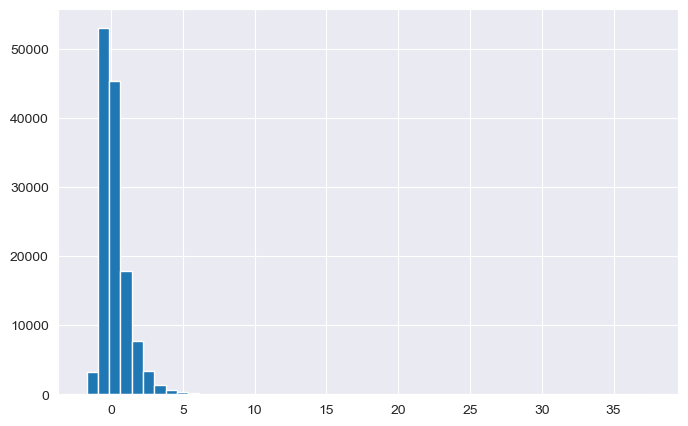

In [60]:
feature_encoder_scaler = FeatureEncoderAndScaler()
X_temp = feature_encoder_scaler.fit_transform(X_temp)
X_temp.num_scaler__calculatedfinishedsquarefeet.hist(bins=50, figsize=(8,5))
plt.show()

#### 11. correlation sanity check

<Axes: >

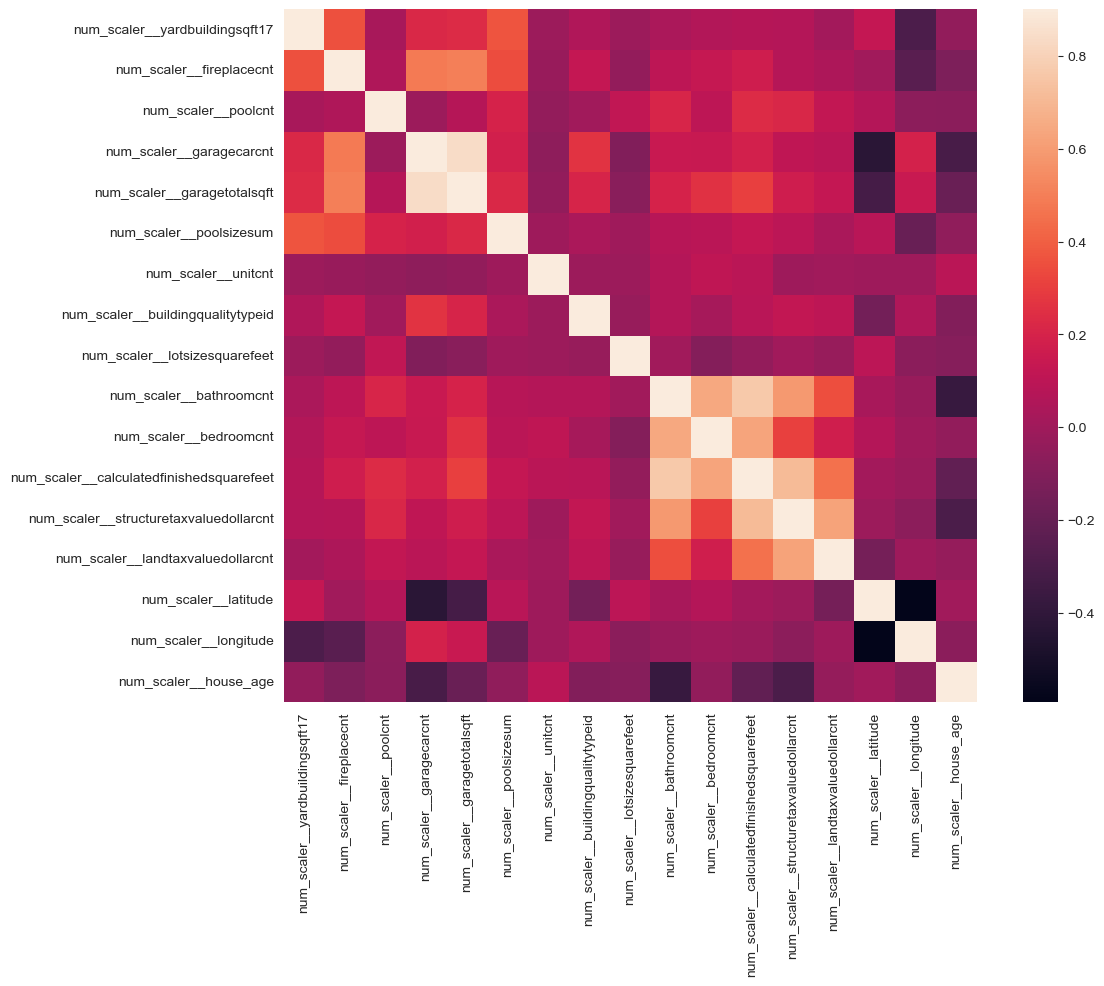

In [61]:
corrmat = X_temp.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

#### 12. create polynomial features

feature^2 , feature^3 , sqrt(feature) 등으로 변수 변환  
=> 선형회귀 등의 모델에 적절하게 활용 가능

In [62]:
# 가장 중요한 변수 찾기

print("Find most important features relative to target")
corr_df = X_temp.copy()
corr_df['logerror'] = y_train.values
corr = corr_df.corr()
most_corr_feat = corr.logerror.abs().sort_values(ascending=False)[1:9].index
most_corr_feat

Find most important features relative to target


Index(['num_scaler__calculatedfinishedsquarefeet', 'num_scaler__bathroomcnt',
       'num_scaler__bedroomcnt', 'num_scaler__structuretaxvaluedollarcnt',
       'num_scaler__house_age', 'num_scaler__garagetotalsqft',
       'num_scaler__garagecarcnt', 'num_scaler__poolcnt'],
      dtype='object')

In [63]:
class CreatePolynomialFeatures(BaseEstimator, TransformerMixin):
    """
    Creates new polynomial features using the 10 most important features relative to the target. 
    3 new polynomial variables for each of the existing features: squared, cubed, sqrt. 
    """
    def __init__(self, most_imp_feat):
        self.most_imp_feat = most_imp_feat
    
    def fit(self, X, y=None):
        return self  # nothing else to do 
    
    def transform(self, X): 
        
        for var in self.most_imp_feat: 
            # New var names 
            s2_var_name = var + '-s2'
            s3_var_name = var + '-s3'
            sq_var_name = var + '-sqrt'
            
            # Create features 
            X[s2_var_name] = X[var] ** 2 
            X[s3_var_name] = X[var] ** 3 
            X[sq_var_name] = np.sqrt(X[var] + abs(min(X[var])))  # Translate feature to ensure min value is 0 before sqrt 
            
        return X

In [64]:
poly_feat_creator = CreatePolynomialFeatures(most_corr_feat)
X_temp = poly_feat_creator.fit_transform(X_temp)

#### 13. skewed features

왜도가 높은 데이터에 대해 Box Cox Transformation 적용

In [65]:
# 왜도가 높은 변수 찾기

numeric_feats = X_temp.dtypes[X_temp.dtypes == 'float'].index
skewed_feats = X_temp[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewed_feats[:20]

num_scaler__calculatedfinishedsquarefeet-s3   277.954
num_scaler__unitcnt                           220.529
num_scaler__bathroomcnt-s3                    136.289
num_scaler__calculatedfinishedsquarefeet-s2   101.162
num_scaler__structuretaxvaluedollarcnt-s3      98.535
num_scaler__garagetotalsqft-s3                 98.294
num_scaler__garagecarcnt-s3                    79.236
num_scaler__structuretaxvaluedollarcnt-s2      55.398
num_scaler__bedroomcnt-s3                      43.116
num_scaler__lotsizesquarefeet                  26.835
num_scaler__garagetotalsqft-s2                 24.628
num_scaler__bathroomcnt-s2                     18.723
num_scaler__bedroomcnt-s2                      13.909
num_scaler__garagecarcnt-s2                    13.487
num_scaler__yardbuildingsqft17                 12.273
num_scaler__landtaxvaluedollarcnt              11.997
num_scaler__poolsizesum                        10.773
num_scaler__structuretaxvaluedollarcnt          8.162
num_scaler__house_age-s3    

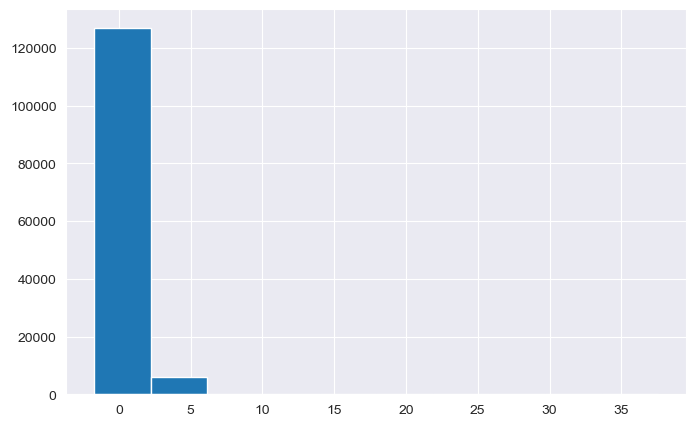

In [68]:
X_temp.num_scaler__calculatedfinishedsquarefeet.hist(bins=10,figsize=(8,5))
plt.show()

In [69]:
from datetime import date
from scipy.special import boxcox1p

class BoxCoxSkewedFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, skewness_thres=0.75):
        self.skewness_thres = skewness_thres

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        numeric_feats = X.dtypes[X.dtypes == 'float'].index
        skewed_feats = X[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
        skewed_feats = skewed_feats[abs(skewed_feats) > self.skewness_thres].index
        lam = 0.18
        for feat in skewed_feats:
            X[feat] = X[feat] + abs(min(X[feat]))
            X[feat] = boxcox1p(X[feat], lam)
        return X

In [70]:
skew_transformer = BoxCoxSkewedFeatures()
X_temp = skew_transformer.transform(X_temp)

In [71]:
numeric_feats = X_temp.dtypes[X_temp.dtypes == 'float'].index
skewed_feats = X_temp[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewed_feats[:20]

num_scaler__poolsizesum                       9.398
num_scaler__calculatedfinishedsquarefeet-s3   6.774
num_scaler__structuretaxvaluedollarcnt-s3     6.720
num_scaler__unitcnt                           6.238
num_scaler__yardbuildingsqft17                5.784
num_scaler__structuretaxvaluedollarcnt-s2     4.632
num_scaler__bathroomcnt-s3                    4.027
num_scaler__bedroomcnt-s2                     3.458
num_scaler__garagecarcnt-s3                   3.421
num_scaler__calculatedfinishedsquarefeet-s2   3.332
num_scaler__bedroomcnt-s3                     3.188
num_scaler__lotsizesquarefeet                 3.147
num_scaler__fireplacecnt                      3.005
num_scaler__bathroomcnt-s2                    2.476
num_scaler__structuretaxvaluedollarcnt        1.797
num_scaler__landtaxvaluedollarcnt             1.784
num_scaler__garagecarcnt-s2                   1.719
num_scaler__poolcnt-sqrt                      1.465
num_scaler__poolcnt-s3                        1.465
num_scaler__

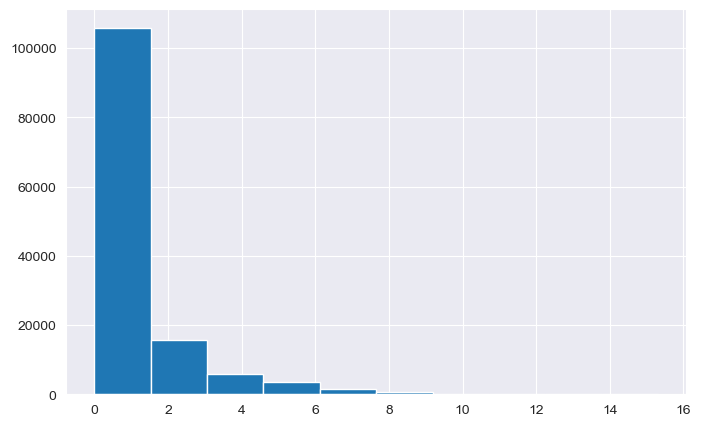

In [72]:
X_temp.num_scaler__lotsizesquarefeet.hist(bins=10, figsize=(8,5))
plt.show()

#### 14. Ordinal Encoding Categorical Variables

이 데이터에는 없으므로 생략

### Full Data Preparation Pipeline

In [73]:
X_prepared = X_train.copy()
X_prepared_val = X_val.copy()

In [74]:
# Feature Dropper Pipeline
feature_dropper = FeatureDropper(features_to_drop=lin_reg_drop_vars)

# Convert Date Features Pipeline
year_feat_creator = CreateYearFeatures(date_features=date_features)

# Feature Encoding and Scaling Pipeline
feature_encoder_scaler = FeatureEncoderAndScaler()

# Transform Skewed Numerical Features Pipeline
skew_transformer = BoxCoxSkewedFeatures()


# univariate / multivariate 두 가지 버전 중 univariate로 실행하겟음
convert_to_bool = ["pooltypeid2", "decktypeid", "taxdelinquencyflag"] 
convert_to_string= ["airconditioningtypeid", "heatingorsystemtypeid", "fips", "propertylandusetypeid", "regionidcounty"]
univariate_impute_pipe = ColumnTransformer([
        ("impute_0", SimpleImputer(strategy="constant", fill_value=0), impute_0_vars),
        ("impute_mode", SimpleImputer(strategy="most_frequent"), impute_mode_vars),
        ("impute_median", SimpleImputer(strategy="median"), impute_median_vars),
    ],
    remainder='passthrough'
)
col_name_appender = ColumnNamesAppender(univariate_impute_pipe, X_train.columns, num_transformers=3)
feature_type_changer = ConvertFeatureType(convert_to_int=convert_to_int, convert_to_string=convert_to_string, 
                                          convert_to_float=convert_to_float, convert_to_bool=convert_to_bool)
poly_feat_creator = CreatePolynomialFeatures(most_corr_feat)

# 2) Multivariate Version

# convert_to_string= ["airconditioningtypeid", "heatingorsystemtypeid", "fips", "propertylandusetypeid", "regionidcounty", "pooltypeid2", "decktypeid", "taxdelinquencyflag"]
# multivariate_impute_pipe = ColumnTransformer([
#         ("impute_cats", SimpleImputer(strategy="constant", fill_value='missing'), cat_impute_vars),
#         ("impute_num", IterativeImputer(estimator=RandomForestRegressor(n_estimators=10, max_depth=30, min_samples_leaf=32), random_state=0, max_iter=1), numeric_impute_vars),
#     ],
#     remainder='passthrough'
# )
# col_name_appender = ColumnNamesAppender(multivariate_impute_pipe, X_train.columns, num_transformers=3)
# feature_type_changer = ConvertFeatureType(convert_to_int=convert_to_int, convert_to_string=convert_to_string, convert_to_float=convert_to_float)
# # most_corr_feat = list(map(lambda x: x.replace('num_scaler__',''), most_corr_feat))     # Clean up feature names by removing `num_scaler__`
# poly_feat_creator = CreatePolynomialFeatures(most_corr_feat)

In [75]:
lin_reg_preprocessor = Pipeline([
    ('feature_dropper', feature_dropper),
    ('univariate_impute_pipe', univariate_impute_pipe),
    # ('multivariate_impute_pipe', multivariate_impute_pipe),
    ('col_name_appender', col_name_appender),
    ('feature_type_creator', feature_type_changer),
    ('year_feat_creator', year_feat_creator),
    ('feature_encoder_scaler', feature_encoder_scaler),
    ('poly_feat_creator', poly_feat_creator),
    ('skew_transformer', skew_transformer)
])

data_prep_pipe = lin_reg_preprocessor.fit(X_prepared)
X_prepared = lin_reg_preprocessor.transform(X_prepared)
X_prepared_val = lin_reg_preprocessor.transform(X_prepared_val)

In [76]:
from sklearn import set_config
set_config(display='diagram')
lin_reg_preprocessor

Pipeline(steps=[('feature_dropper',
                 FeatureDropper(features_to_drop=['finishedsquarefeet13',
                                                  'finishedsquarefeet15',
                                                  'finishedfloor1squarefeet',
                                                  'finishedsquarefeet50',
                                                  'storytypeid',
                                                  'architecturalstyletypeid',
                                                  'buildingclasstypeid',
                                                  'typeconstructiontypeid',
                                                  'finishedsquarefeet6',
                                                  'pooltypeid10', 'pooltypeid7',
                                                  'hashottuborspa',
                                                  'fireplaceflag',
                                                  'threequarterb...
                ('poly_feat_creator',
                 CreatePolynomialFeatures(most_imp_feat=Index(['num_scaler__calculatedfinishedsquarefeet', 'num_scaler__bathroomcnt',
       'num_scaler__bedroomcnt', 'num_scaler__structuretaxvaluedollarcnt',
       'num_scaler__house_age', 'num_scaler__garagetotalsqft',
       'num_scaler__garagecarcnt', 'num_scaler__poolcnt'],
      dtype='object'))),
                ('skew_transformer', BoxCoxSkewedFeatures())])

## 모델링

### Select and Train Models

In [78]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer

In [79]:
# 기본 선형회귀 모델로 베이스라인 점수를 내기 위한 일부 예측값 도출하기

lin_reg = LinearRegression()
lin_reg.fit(X_prepared, y_train)

some_data = X_train.iloc[:5]
some_labels = y_train.iloc[:5]
some_data_prepared = data_prep_pipe.transform(some_data)

print("predictions:", lin_reg.predict(some_data_prepared))
print("labels:", list(some_labels))

predictions: [ 0.08364916 -0.07890773 -0.08990026 -0.03764653 -0.0796206 ]
labels: [-0.104536755154, 0.036743366071, -0.0136873002723, -0.106598394839, -0.0325]


### Model Evaluation

MAE랑 RMSE를 이용해서 모델을 비교해볼 예정,,

In [80]:
# baseline for RMSE

print(f"MAE Baseline: {y_train.mad()}")  # median absolute deviation
print(f"RMSE Baseline: {y_train.std()}")

MAE Baseline: 0.053376653491177956
RMSE Baseline: 0.08371665588521855


In [85]:
def get_eval_metrics(models, X, y_true):
    for model in models:
        y_pred = model.predict(X)
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        mae = mean_absolute_error(y_true,y_pred)
        print(f"Model: {model}")
        print(f"MAE: {mae}, RMSE: {rmse}")

In [86]:
get_eval_metrics([lin_reg], X_prepared_val, y_val)

Model: LinearRegression()
MAE: 0.0529908612772384, RMSE: 0.08361090818075079


In [87]:
def display_scores(model, scores):
    print("-"*50)
    print("Model:", model)
    print("\nScores:", scores)
    print("\nMean:", scores.mean())
    print("\nStandard deviation:", scores.std())
    
def get_cross_val_scores(models, X, y, cv=10, fit_params=None):
    """
    Performs k-fold cross validation and calculates MAE for each fold for all input models. 
    `models`: list of fit models 
    """    
    for model in models: 
        mae = -cross_val_score(model, X, y, scoring="neg_mean_absolute_error", cv=cv, fit_params=fit_params)
        display_scores(model, mae) 

In [88]:
get_cross_val_scores([lin_reg], X_prepared, y_train, cv=5)

--------------------------------------------------
Model: LinearRegression()

Scores: [5.34901066e-02 8.19397863e+04 8.37232179e+04 5.33316254e-02
 2.23078319e+04]

Mean: 37594.18859547543

Standard deviation: 37827.8471134355


### 1. Linear Regression Models

### 2. Decision Trees & Random Forest Models

### 3. Support Vector Machines(SVM)

### 4. Gradient Boosting Machines

#### 4-1. XGBoost

In [89]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer

In [90]:
X_prepared = X_train.copy()
X_prepared_val = X_val.copy()

In [91]:
xgb_drop = ['parcelid']
feature_dropper = FeatureDropper(features_to_drop=xgb_drop)

year_feat_creator = CreateYearFeatures(date_features = date_features)
date_feat_creator = CreateDateFeatures()

cat_vars = ['transaction_year', 'transaction_month', 'transaction_day', 'transaction_quarter', 'airconditioningtypeid', 'architecturalstyletypeid', 'buildingclasstypeid', 'buildingqualitytypeid', 'decktypeid', 'fips',  'hashottuborspa', 'heatingorsystemtypeid',  'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'propertycountylandusecode', 'propertylandusetypeid', 'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 'regionidzip', 'storytypeid',  'typeconstructiontypeid', 'fireplaceflag',  'assessmentyear', 'taxdelinquencyflag', 'taxdelinquencyyear', 'censustractandblock']
feature_encoder = ColumnTransformer([("ohe_cats", OneHotEncoder(handle_unknown='ignore'), cat_vars)], remainder='passthrough')

In [92]:
xgb_preprocessor = Pipeline([
    ('feature_dropper', feature_dropper),
    ('date_feat_creator', date_feat_creator),
    ('year_feat_creator', year_feat_creator),
    ('feature_encoder', feature_encoder)
])

data_prep_pipe = xgb_preprocessor.fit(X_prepared)
X_prepared = xgb_preprocessor.transform(X_prepared)
X_prepared_val = xgb_preprocessor.transform(X_prepared_val)

In [93]:
X_xgb = X_prepared.copy()
X_xgb_val = X_prepared_val.copy()

In [94]:
params = {
    'learning_rate': 0.3,
    'n_estimators': 10000,
    'random_state': 42
}

xgb_base = xgb.XGBRegressor(**params)

In [95]:
fit_params = {'early_stopping_rounds': 10,
              'eval_metric': 'mae',
              'eval_set': [[X_prepared_val, y_val]]}

xgb_base.fit(X_prepared, y_train, **fit_params)

[0]	validation_0-mae:0.34306
[1]	validation_0-mae:0.24220
[2]	validation_0-mae:0.17379
[3]	validation_0-mae:0.12800
[4]	validation_0-mae:0.09802
[5]	validation_0-mae:0.07900
[6]	validation_0-mae:0.06739
[7]	validation_0-mae:0.06068
[8]	validation_0-mae:0.05695
[9]	validation_0-mae:0.05497
[10]	validation_0-mae:0.05391
[11]	validation_0-mae:0.05336
[12]	validation_0-mae:0.05304
[13]	validation_0-mae:0.05288
[14]	validation_0-mae:0.05279
[15]	validation_0-mae:0.05273
[16]	validation_0-mae:0.05268
[17]	validation_0-mae:0.05265
[18]	validation_0-mae:0.05264
[19]	validation_0-mae:0.05264
[20]	validation_0-mae:0.05264
[21]	validation_0-mae:0.05264
[22]	validation_0-mae:0.05263
[23]	validation_0-mae:0.05263
[24]	validation_0-mae:0.05263
[25]	validation_0-mae:0.05263
[26]	validation_0-mae:0.05263
[27]	validation_0-mae:0.05263
[28]	validation_0-mae:0.05263
[29]	validation_0-mae:0.05264
[30]	validation_0-mae:0.05264
[31]	validation_0-mae:0.05264
[32]	validation_0-mae:0.05265
[33]	validation_0-ma

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

##### hyperopt 패캐지를 이용한 파라미터 튜닝

In [97]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [98]:
def eval_model(params):
    xgb_base = xgb.XGBRegressor()
    xgb_base.set_params(**params)

    fit_params = {'early_stopping_rounds': 15,
              'eval_metric': 'mae',
              'eval_set': [[X_prepared_val, y_val]]}
    mae = -cross_val_score(xgb_base, X_prepared, y_train, scoring='neg_mean_absolute_error', cv=3, fit_params=fit_params)
    mae = mae.mean()
    return(mae)

In [99]:
# parameter space

fspace1 = {
    'max_depth':hp.randint('max_depth', 3), # 원래 7인데 시간 이슈로 줄임..
    'colsample_bynode': hp.uniform('colsample_bynode',.3,1),
    'subsample': hp.quniform('subsample',.3, 1,.05),
    'gamma':hp.uniform('gamma',.2, 5),
    'tree_method': hp.choice('tree_method', ['approx', 'exact']),
    'n_estimators': 10000,
    'learning_rate': 0.15,
    'random_state': 42,
}

In [101]:
trials1 = Trials()
best_param = fmin(fn=eval_model, space=fspace1, algo=tpe.suggest, max_evals=5, trials=trials1)

[0]	validation_0-mae:0.41644                         
[1]	validation_0-mae:0.35406                         
[2]	validation_0-mae:0.30157                         
[3]	validation_0-mae:0.25752                         
[4]	validation_0-mae:0.22060                         
[5]	validation_0-mae:0.18965                         
[6]	validation_0-mae:0.16381                         
[7]	validation_0-mae:0.14239                         
[8]	validation_0-mae:0.12463                         
[9]	validation_0-mae:0.11000                         
[10]	validation_0-mae:0.09804                        
[11]	validation_0-mae:0.08833                        
[12]	validation_0-mae:0.08054                        
[13]	validation_0-mae:0.07429                        
[14]	validation_0-mae:0.06934                        
[15]	validation_0-mae:0.06546                        
[16]	validation_0-mae:0.06247                        
[17]	validation_0-mae:0.06017                        
[18]	validation_0-mae:0.0584

In [102]:
best_param    # max depth? tree_method에 뭔가 문제가 있는듯함,,,,시간 많을 때 실험 많이 돌려볼 필요가 잇음

{'colsample_bynode': 0.4306204992452154,
 'gamma': 0.7976594084520396,
 'max_depth': 0,
 'subsample': 0.75,
 'tree_method': 0}

In [107]:
fit_params = {'early_stopping_rounds': 15,
              'eval_metric': 'mae',
              'eval_set': [[X_prepared_val, y_val]]}

best_params = {'colsample_bynode': 0.4306204992452154,
 'gamma': 0.7976594084520396,
 'max_depth': 3,   # 임의로 수정함
 'subsample': 0.75,
 'tree_method': 'exact', # 임의로 수정함
 'n_estimators': 10000,
 'learning_rate': 0.15,
 'random_state': 42}

xgb_base = xgb.XGBRegressor(**best_params)
xgb_base.fit(X_prepared, y_train, **fit_params)
get_cross_val_scores([xgb_base], X_prepared, y_train, cv=3, fit_params=fit_params)

[0]	validation_0-mae:0.41640
[1]	validation_0-mae:0.35399
[2]	validation_0-mae:0.30143
[3]	validation_0-mae:0.25734
[4]	validation_0-mae:0.22039
[5]	validation_0-mae:0.18948
[6]	validation_0-mae:0.16367
[7]	validation_0-mae:0.14222
[8]	validation_0-mae:0.12445
[9]	validation_0-mae:0.10983
[10]	validation_0-mae:0.09783
[11]	validation_0-mae:0.08810
[12]	validation_0-mae:0.08030
[13]	validation_0-mae:0.07405
[14]	validation_0-mae:0.06911
[15]	validation_0-mae:0.06525
[16]	validation_0-mae:0.06226
[17]	validation_0-mae:0.05997
[18]	validation_0-mae:0.05826
[19]	validation_0-mae:0.05695
[20]	validation_0-mae:0.05597
[21]	validation_0-mae:0.05523
[22]	validation_0-mae:0.05467
[23]	validation_0-mae:0.05425
[24]	validation_0-mae:0.05394
[25]	validation_0-mae:0.05370
[26]	validation_0-mae:0.05353
[27]	validation_0-mae:0.05339
[28]	validation_0-mae:0.05329
[29]	validation_0-mae:0.05322
[30]	validation_0-mae:0.05316
[31]	validation_0-mae:0.05311
[32]	validation_0-mae:0.05307
[33]	validation_0-ma

#### 4-2. LightGBM

#### 4-3. CatBoost

### Model Interpretability